# Adaptive - Ijsselmeer

Author: Luciano Raso, Delft University of Technology, Delft, The Netherlands. Section of Policy Analysis  
email: l.raso@tudelft.nl

In [1]:
cd ..

/Users/lraso/Documents/working directories/Monitoring_for_DAPP/Experiments


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import ast
from pathways.pathways import get_policy_def, find_pathway
from ema_workbench import load_results
import collections

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Load data

In [3]:
# load data from EMA
results_df = pd.read_csv('data/Ijsselmeer/2018_10_18_results.csv',index_col=0)
len(results_df)
results_df.head()

2744

,low_flow_shift,peak_inflow_multiplier,sea_level_shift,pump_capacity,sluices_widening,summer_target,scenario_id,policy,model,demand deficit relative,dike failure frequency
0,0.0,1.0,0.000000,0,1,-0.2,0,"{'pump_capacity': 0, 'summer_target': -0.2, 's...",Ijsselmeer,0.014309,3714.848248
1,0.0,1.0,0.166667,0,1,-0.2,1,"{'pump_capacity': 0, 'summer_target': -0.2, 's...",Ijsselmeer,0.014309,3009.328920
2,0.0,1.0,0.333333,0,1,-0.2,2,"{'pump_capacity': 0, 'summer_target': -0.2, 's...",Ijsselmeer,0.014309,2034.670790
3,0.0,1.0,0.500000,0,1,-0.2,3,"{'pump_capacity': 0, 'summer_target': -0.2, 's...",Ijsselmeer,0.014201,1488.848525
4,0.0,1.0,0.666667,0,1,-0.2,4,"{'pump_capacity': 0, 'summer_target': -0.2, 's...",Ijsselmeer,0.014001,1052.332495


### Specify policy dimensions

In [121]:
actions_name = ['pump_capacity','sluices_widening','summer_target']
critical_uncertainties = ['low_flow_shift', 'peak_inflow_multiplier', 'sea_level_shift']
objectives = ['dike failure frequency','demand deficit relative']

In [130]:
color_list = ['clMaroon','clNavy','clOlive','clGreen','clPurple','clOrange','clYellow']
actions = []
for i, action_name in enumerate(actions_name):
    actions.append({'name':action_name, 
                    'caption': action_name, 
                    'color': color_list[i],
                    'predecessor':'current_situation'}) 

decreasing_actions = []#['winter_target'] # list actions whose effectiveness increase with decreasing of action value, default increasing
for action in actions:
    direction = -1 if action in decreasing_actions else 1
    action['values'] = np.sort(results_df[action['name']].unique())[::direction].tolist()

In [131]:
actions


[{'caption': 'pump_capacity',
  'color': 'clMaroon',
  'name': 'pump_capacity',
  'predecessor': 'current_situation',
  'values': [0, 500]},
 {'caption': 'sluices_widening',
  'color': 'clNavy',
  'name': 'sluices_widening',
  'predecessor': 'current_situation',
  'values': [1, 2]},
 {'caption': 'summer_target',
  'color': 'clOlive',
  'name': 'summer_target',
  'predecessor': 'current_situation',
  'values': [-0.2, 0.2]}]

### 2-action Pathways 

We consider only pathways made of two actions (because the Deltares Pathway Generator does not include pathways made of more than two actions)

In [170]:
pathways = []
for i, action in enumerate(actions):
    left_actions = actions[i+1:]
    for combined_action in left_actions:
        pathway = {'name': action['name'],
                   'caption': action['name'] + ' + ' + combined_action['name'],
                   'combined_to': combined_action['name'],
                   'predecessor': action['name'],
                   'color': action['color'], 
                   'values': [action['values'][-1]]}
        pathways.append(pathway)

In [171]:
pathways

[{'caption': 'pump_capacity + sluices_widening',
  'color': 'clMaroon',
  'combined_to': 'sluices_widening',
  'name': 'pump_capacity',
  'predecessor': 'pump_capacity',
  'values': [500]},
 {'caption': 'pump_capacity + summer_target',
  'color': 'clMaroon',
  'combined_to': 'summer_target',
  'name': 'pump_capacity',
  'predecessor': 'pump_capacity',
  'values': [500]},
 {'caption': 'sluices_widening + summer_target',
  'color': 'clNavy',
  'combined_to': 'summer_target',
  'name': 'sluices_widening',
  'predecessor': 'sluices_widening',
  'values': [2]}]

In [172]:
# var new_var correspondence
name_crit_unc ={'low_flow_shift':'low flow reduction $[m^3/s]$',
      'peak_inflow_multiplier': 'max discharge increase $[\%]$ ',
      'sea_level_shift': 'sea level rise $[m]$',
      'wind_multiplier' : 'change wind speed, $[\%]$ '}
     # 'winter_target': 'winter target level $[mNAP]$',}
    
    

In [173]:
# rename
old_var_name = results_df.columns.copy(deep=True)
new_var_name = [ name_crit_unc[var] if var in name_crit_unc else var for var in old_var_name  ]
results_df.columns = new_var_name

### define scenarios data

In [174]:
scenarios_df = results_df.iloc[results_df['scenario_id'].unique(),0:len(critical_uncertainties)]
scenarios_df.shape

(343, 3)

### Define policy success

In [175]:
policy_success_threshold = {}
policy_success_threshold['dike failure frequency'] = 3000
policy_success_threshold['demand deficit relative'] = 0.01 # in *100 %

sign = {} # negative is the objective to be minimized, positive if to be maximized 
sign['dike failure frequency'] = -1
sign['demand deficit relative'] = +1

### Identify policy success scenarios

In [176]:
policy_success = pd.DataFrame(results_df[['policy','scenario_id']])
for objective in objectives:
    policy_success[objective] = sign[objective] * results_df[objective] <= sign [objective] * policy_success_threshold[objective]

#### overall success of policy success is if all criteria are satisfied 

In [177]:
policy_success['overall']= policy_success[objectives].all(axis=1)

#### Pivot policy-success results in scenarios (rows) vs policy (columns) table

In [178]:
success_per_policy = policy_success.pivot(columns='policy', values='overall', index='scenario_id')   
policies = success_per_policy.columns
success_per_policy.sum()

policy
{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 1}       10
{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 2}       80
{'pump_capacity': 0, 'summer_target': 0.2, 'sluices_widening': 1}        58
{'pump_capacity': 0, 'summer_target': 0.2, 'sluices_widening': 2}       155
{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 1}    136
{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 2}    136
{'pump_capacity': 500, 'summer_target': 0.2, 'sluices_widening': 1}     200
{'pump_capacity': 500, 'summer_target': 0.2, 'sluices_widening': 2}     197
dtype: int64

## Identify Adaptation Tipping Points by scenario discovery

### Find ATP on the space of critical uncertainties 

#### Use of Classification Tree (CART)

In [179]:
from sklearn import tree
tree_decision = tree.DecisionTreeClassifier(criterion='gini',max_depth=3)

In [180]:
adaptation_tree={}
features = {}
thresholds = {}
for policy in policies:
    adaptation_tree[policy] = tree_decision.fit(scenarios_df,success_per_policy[policy])
    features[policy] = adaptation_tree[policy].tree_.feature
    thresholds[policy] = adaptation_tree[policy].tree_.threshold

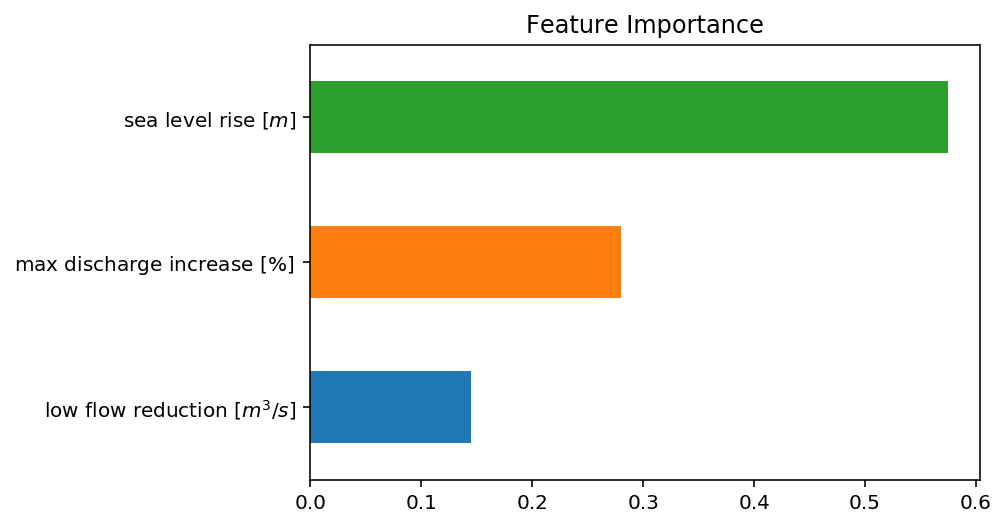

In [181]:
clf = adaptation_tree[policy]
feature_importance = pd.Series(clf.feature_importances_,index=scenarios_df.columns)
feature_importance.plot(kind='barh',title='Feature Importance')

#### Use of Range Search (PRIM)

In [182]:
from ema_workbench.analysis import prim

In [183]:
boxes = {}
ATP = {}
box_single_signpost = {}
upper_lim = 1

for policy in policies:
    x = scenarios_df.to_records(index=False)
    y = success_per_policy[policy].values
    prim_alg = prim.Prim(x, y, threshold=0.3)
    box = prim_alg.find_box()
    boxes[policy] = box
    
    # criteria : single sigpost with the largest density
    i = max(box.peeling_trajectory.index[box.peeling_trajectory['res dim'] == 1])
    print(i)
    ATP[policy] = box.box_lims[i][:][upper_lim]

/Users/lraso/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


3
1
5
3
1
1
1
2


In [184]:
ATP

{"{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 1}": (100., 1.75, 1.),
 "{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 2}": (100., 2., 1.),
 "{'pump_capacity': 0, 'summer_target': 0.2, 'sluices_widening': 1}": (100., 2., 0.25),
 "{'pump_capacity': 0, 'summer_target': 0.2, 'sluices_widening': 2}": (100., 2., 0.58333333),
 "{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 1}": (100., 2., 1.),
 "{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 2}": (100., 2., 1.),
 "{'pump_capacity': 500, 'summer_target': 0.2, 'sluices_widening': 1}": (100., 2., 0.91666667),
 "{'pump_capacity': 500, 'summer_target': 0.2, 'sluices_widening': 2}": (100., 2., 0.75)}

#### ZOOM IN: tradeoff density-coverage

In [239]:
b = boxes["{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 1}"]
ATP["{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 1}"]

(100., 1.75, 1.)

In [242]:
b.box_lims

[array([(  0., 1., 0.), (100., 2., 1.)],
       dtype=(numpy.record, [('low flow reduction $[m^3/s]$', '<f8'), ('max discharge increase $[\\%]$ ', '<f8'), ('sea level rise $[m]$', '<f8')])),
 array([(  0., 1.        , 0.), (100., 1.91666667, 1.)],
       dtype=(numpy.record, [('low flow reduction $[m^3/s]$', '<f8'), ('max discharge increase $[\\%]$ ', '<f8'), ('sea level rise $[m]$', '<f8')])),
 array([(  0., 1.  , 0.), (100., 1.75, 1.)],
       dtype=(numpy.record, [('low flow reduction $[m^3/s]$', '<f8'), ('max discharge increase $[\\%]$ ', '<f8'), ('sea level rise $[m]$', '<f8')])),
 array([(  0., 1.08333333, 0.), (100., 1.75      , 1.)],
       dtype=(numpy.record, [('low flow reduction $[m^3/s]$', '<f8'), ('max discharge increase $[\\%]$ ', '<f8'), ('sea level rise $[m]$', '<f8')])),
 array([(  0., 1.08333333, 0.        ), (100., 1.75      , 0.91666667)],
       dtype=(numpy.record, [('low flow reduction $[m^3/s]$', '<f8'), ('max discharge increase $[\\%]$ ', '<f8'), ('sea level r

In [241]:
b.box_lim = b.box_lims[1]

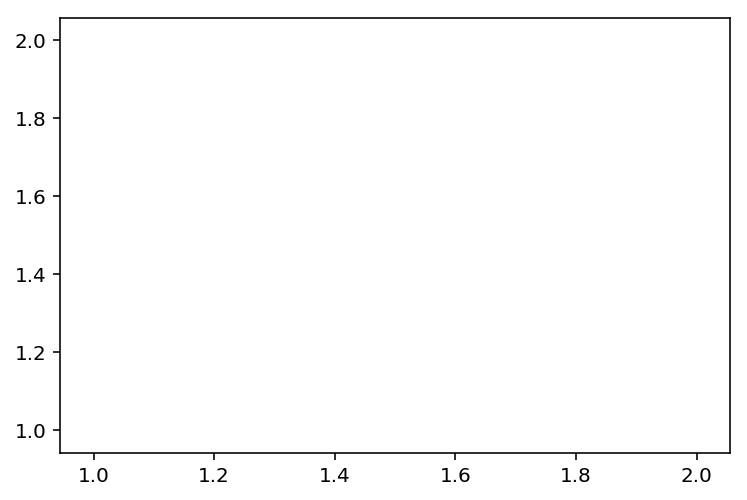

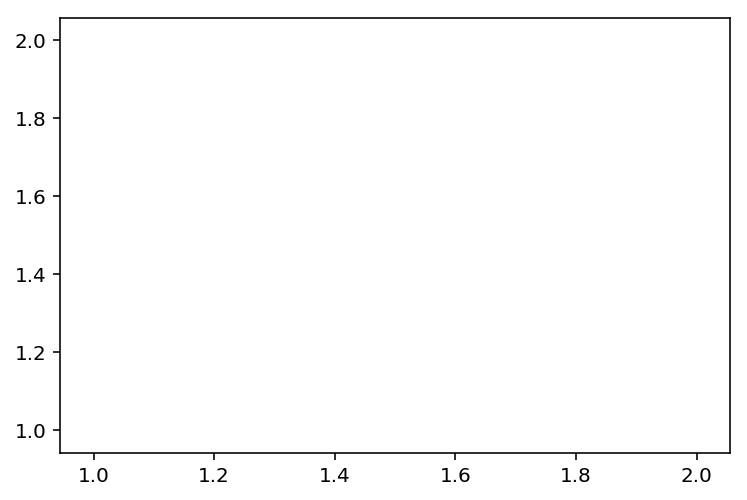

In [238]:
b.show_pairs_scatter()
plt.show()

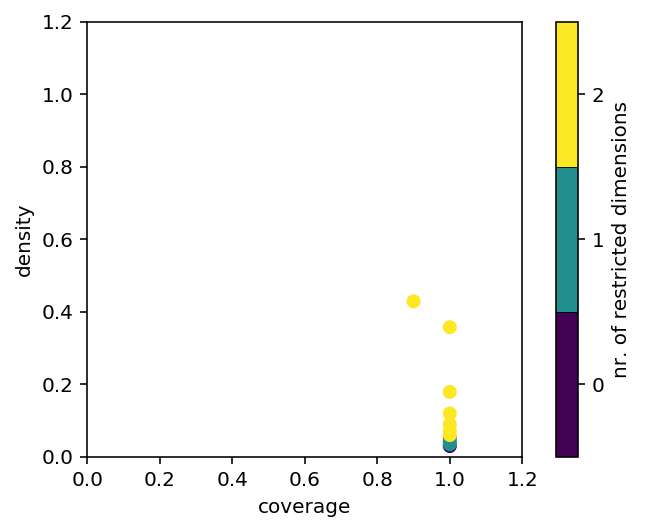

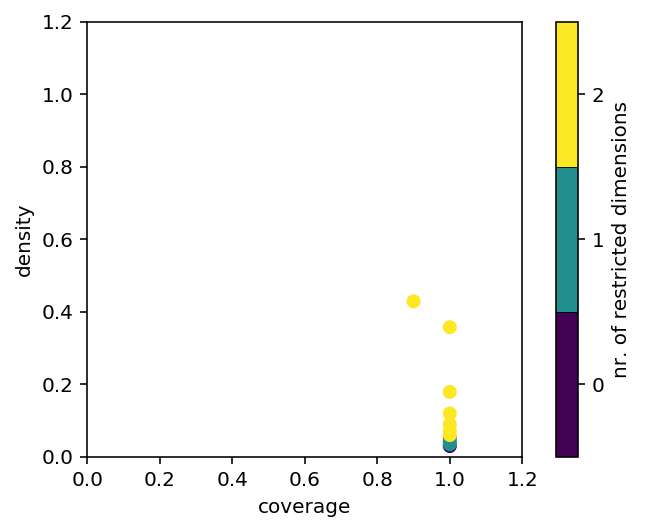

In [233]:
b.show_tradeoff()
plt.show()

In [225]:
b.peeling_trajectory
plt.show()
f = (b.peeling_trajectory.coverage + b.peeling_trajectory.density)/2
b.inspect(int(f.argmax()))

,coverage,density,mass,mean,res dim
0,1.0,0.029155,1.000000,0.029155,0
1,1.0,0.034014,0.857143,0.034014,1
2,1.0,0.040816,0.714286,0.040816,1
3,1.0,0.051020,0.571429,0.051020,1
4,1.0,0.059524,0.489796,0.059524,2
5,1.0,0.071429,0.408163,0.071429,2
6,1.0,0.089286,0.326531,0.089286,2
7,1.0,0.119048,0.244898,0.119048,2
8,1.0,0.178571,0.163265,0.178571,2
9,1.0,0.357143,0.081633,0.357143,2


coverage            1
density      0.357143
mass        0.0816327
mean         0.357143
res dim             2
Name: 9, dtype: object

                                   box 9            \
                                     min       max   
sea level rise $[m]$            0.000000  0.083333   
max discharge increase $[\%]$   1.083333  1.750000   

                                                                            
                                                                 qp values  
sea level rise $[m]$                               [4.509816589172546e-07]  
max discharge increase $[\%]$   [0.21969658893269797, 0.08673206235375282]  



/Users/lraso/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


In [191]:
max(b.peeling_trajectory.index[b.peeling_trajectory['res dim'] == 1])


3

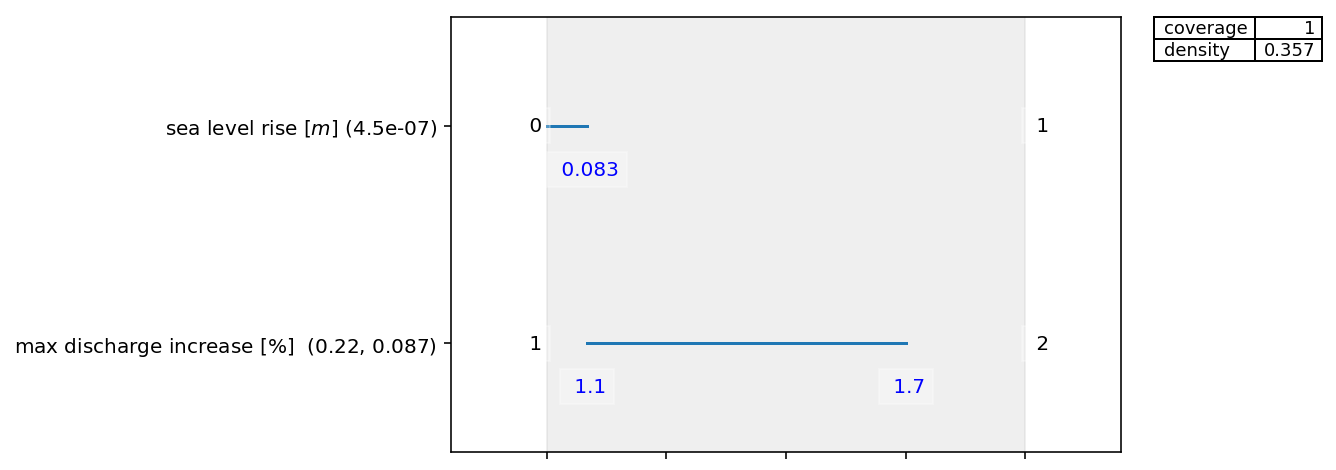

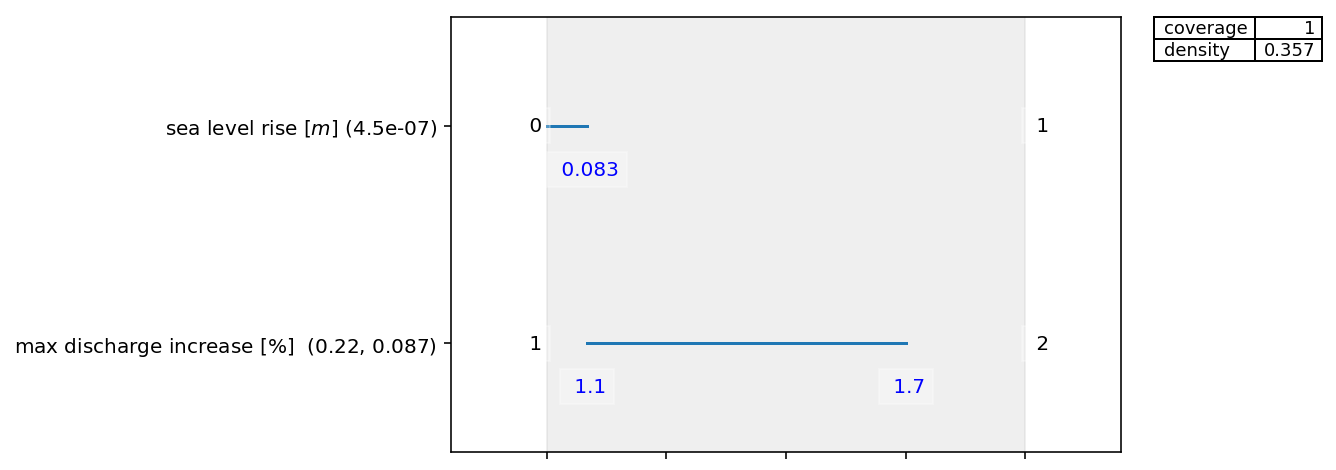

In [192]:
b.inspect(int(f.idxmax()),style='graph')

In [226]:
b.box_lim = b.box_lims[1]

In [227]:
b.inspect(2)

coverage            1
density     0.0408163
mass         0.714286
mean        0.0408163
res dim             1
Name: 2, dtype: object

                               box 2                             
                                 min   max              qp values
max discharge increase $[\%]$    1.0  1.75  [0.18136160458772901]



coverage            1
density     0.0595238
mass         0.489796
mean        0.0595238
res dim             2
Name: 4, dtype: object

                                   box 4            \
                                     min       max   
max discharge increase $[\%]$   1.083333  1.750000   
sea level rise $[m]$            0.000000  0.916667   

                                                                          
                                                               qp values  
max discharge increase $[\%]$   [0.2802871139587463, 0.1330326719171272]  
sea level rise $[m]$                                [0.3548076396308219]  



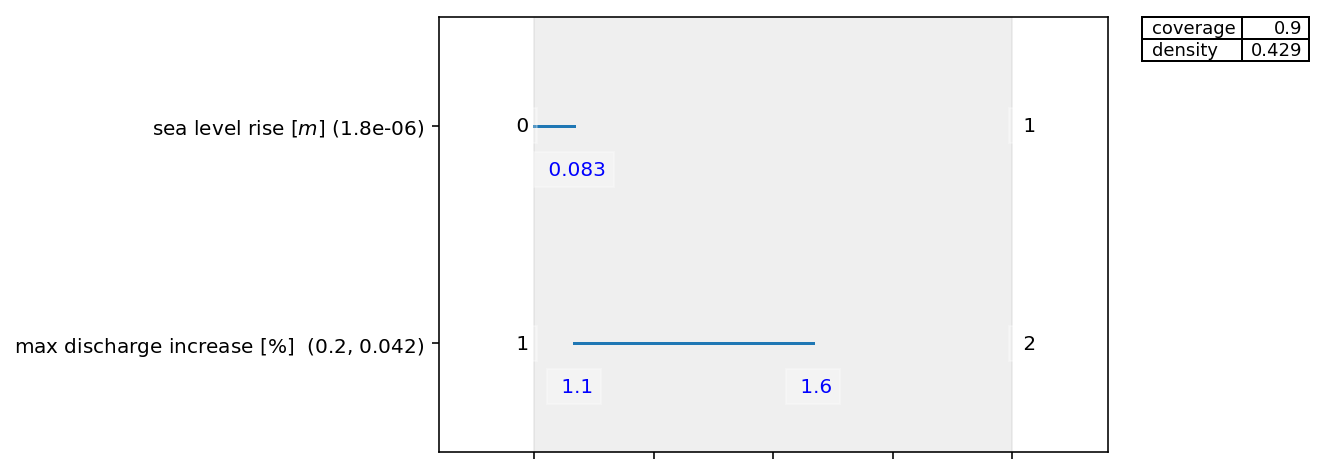

In [195]:
box_id=None
box_res = b.inspect(4)
box_res2 = b.inspect(box_id,style='graph')


### Rendering adaptation pathways
#### Creating xml to be loaded within the [Pathways Generator](https://publicwiki.deltares.nl/display/AP/Pathways+Generator) by [Deltares](www.deltares/nl)

In [196]:
from pathways.pathways import create_patwhays_map

In [197]:
# find correspondence policy as in table to dictionary of actions
correspondence_table = get_policy_def(results_df,actions_name)

In [208]:
# auxiliary functions 
def find_policy_id(policy_dict,correspondence_table):
    for policy_id in correspondence_table:
        if correspondence_table[policy_id]==policy_dict:
            return(policy_id)

def find_policy(elements,precedent_policy,correspondence_table):
    
    for action in elements:
        print (action)
        
        new_policy = precedent_policy.copy()
        
        if 'values' in action: # not current situation
            new_policy[action['name']]=action['values'][-1]

        if 'combined_to' in action: # is a pathway
            value_combined = [combined_action['values'][-1] for combined_action in elements if combined_action['name']==action['combined_to']][0]
            new_policy[action['combined_to']] = value_combined
            
        new_policy_id = find_policy_id(new_policy,correspondence_table)
        action['policy_id'] = new_policy_id
        
        

In [215]:
# add action for current situation

current_situation = {}
for action_name in actions_name:
    action_value = [action['values'][0] for action in actions if action['name']==action_name][0]
    current_situation[action_name] = action_value 

action_current_situation = {'caption':'current_situation', 'name': 'current_situation','color':'clGray','predecessor_id':'-1'}

#action_current_situation['policy_id'] = find_policy_id(current_situation,correspondence_table)
# add current action to list of actins
elements = [action_current_situation] + actions + pathways

In [216]:
elements

[{'caption': 'current_situation',
  'color': 'clGray',
  'name': 'current_situation',
  'predecessor_id': '-1'},
 {'caption': 'pump_capacity',
  'color': 'clMaroon',
  'name': 'pump_capacity',
  'policy_id': "{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 1}",
  'predecessor': 'current_situation',
  'tippingpointvalue': 2.0,
  'values': [0, 500]},
 {'caption': 'sluices_widening',
  'color': 'clNavy',
  'name': 'sluices_widening',
  'policy_id': "{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 2}",
  'predecessor': 'current_situation',
  'tippingpointvalue': 2.0,
  'values': [1, 2]},
 {'caption': 'summer_target',
  'color': 'clOlive',
  'name': 'summer_target',
  'policy_id': "{'pump_capacity': 0, 'summer_target': 0.2, 'sluices_widening': 1}",
  'predecessor': 'current_situation',
  'tippingpointvalue': 2.0,
  'values': [-0.2, 0.2]},
 {'caption': 'pump_capacity + sluices_widening',
  'color': 'clMaroon',
  'combined_to': 'sluices_widening',
  'name': '

In [217]:
find_policy(elements,current_situation,correspondence_table)

{'name': 'current_situation', 'predecessor_id': '-1', 'caption': 'current_situation', 'color': 'clGray'}
{'name': 'pump_capacity', 'policy_id': "{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 1}", 'values': [0, 500], 'color': 'clMaroon', 'predecessor': 'current_situation', 'caption': 'pump_capacity', 'tippingpointvalue': 2.0}
{'name': 'sluices_widening', 'policy_id': "{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 2}", 'values': [1, 2], 'color': 'clNavy', 'predecessor': 'current_situation', 'caption': 'sluices_widening', 'tippingpointvalue': 2.0}
{'name': 'summer_target', 'policy_id': "{'pump_capacity': 0, 'summer_target': 0.2, 'sluices_widening': 1}", 'values': [-0.2, 0.2], 'color': 'clOlive', 'predecessor': 'current_situation', 'caption': 'summer_target', 'tippingpointvalue': 2.0}
{'name': 'pump_capacity', 'combined_to': 'sluices_widening', 'policy_id': "{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 2}", 'color': 'clMaroon', 'va

#### select critical uncertainty to render

In [218]:
# select critical uncertainty to render
rendered_uncertainty = 'peak_inflow_multiplier'#'sea_level_shift' # 
pos_rend_unc = critical_uncertainties.index(rendered_uncertainty)

In [219]:
# assign tippingpoint value for the selected critical uncertainty
for action in elements:
    action['tippingpointvalue'] = ATP[action['policy_id']][pos_rend_unc]

In [222]:
ATP

{"{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 1}": (100., 1.75, 1.),
 "{'pump_capacity': 0, 'summer_target': -0.2, 'sluices_widening': 2}": (100., 2., 1.),
 "{'pump_capacity': 0, 'summer_target': 0.2, 'sluices_widening': 1}": (100., 2., 0.25),
 "{'pump_capacity': 0, 'summer_target': 0.2, 'sluices_widening': 2}": (100., 2., 0.58333333),
 "{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 1}": (100., 2., 1.),
 "{'pump_capacity': 500, 'summer_target': -0.2, 'sluices_widening': 2}": (100., 2., 1.),
 "{'pump_capacity': 500, 'summer_target': 0.2, 'sluices_widening': 1}": (100., 2., 0.91666667),
 "{'pump_capacity': 500, 'summer_target': 0.2, 'sluices_widening': 2}": (100., 2., 0.75)}

In [221]:
for el in elements:
    print(el['caption'])
    print(el['tippingpointvalue'])

current_situation
1.7499999999999998
pump_capacity
2.0
sluices_widening
2.0
summer_target
2.0
pump_capacity + sluices_widening
2.0
pump_capacity + summer_target
2.0
sluices_widening + summer_target
2.0


##### Generate pathway file

In [43]:
graph_settings = {'xaxistitle':rendered_uncertainty,'maxtippingpoint':2}
xml_str = create_patwhays_map(elements,graph_settings = graph_settings)

pathway_file = open('figures/Ijsselmeer/'+rendered_uncertainty+'.pathways', 'w')
pathway_file.write(xml_str)
pathway_file.close()

3916

In [44]:
xml_str

'<?xml version="1.0" ?>\n<pathways>\n  <pathwaytype>conditionbased</pathwaytype>\n  <BeginYear>2018</BeginYear>\n  <EndYear>2100</EndYear>\n  <CurrentElement>1</CurrentElement>\n  <element id="1">\n    <ycoord>500</ycoord>\n    <combinationsecond>-1</combinationsecond>\n    <policy_id>{\'pump_capacity\': 0, \'summer_target\': -0.2, \'sluices_widening\': 1}</policy_id>\n    <color>clGray</color>\n    <combinationtype>ctNone</combinationtype>\n    <id>1</id>\n    <predecessor_id>-1</predecessor_id>\n    <predecessorid>-1</predecessorid>\n    <caption>current_situation</caption>\n    <tippingpointvalue>0.25</tippingpointvalue>\n  </element>\n  <element id="2">\n    <combinationsecond>-1</combinationsecond>\n    <values>[0, 500]</values>\n    <ycoord>375</ycoord>\n    <policy_id>{\'pump_capacity\': 500, \'summer_target\': -0.2, \'sluices_widening\': 1}</policy_id>\n    <color>clMaroon</color>\n    <combinationtype>ctNone</combinationtype>\n    <id>2</id>\n    <predecessorid>1</predecessori

## Identify Adaptation Tipping Points, including observational uncertainty

### Find ATP on the space of observable variables

In [45]:
obs_unc_low_flow = 10
obs_unc_peak_discharge = 100 
obs_unc_sea_level = 0.1



obs_unc_comatrix = np.matrix([obs_unc_low_flow,0,0],[0,obs_unc_peak_discharge,0],[0,0,obs_unc_sea_level])

TypeError: data type not understood

In [ ]:
actions

In [ ]:
import graphviz 
from graphviz_tree import *

In [ ]:
test_new = False
if test_new == True:
    export_graphviz_func = export_graphviz_temp
else:
    export_graphviz_func = tree.export_graphviz

In [ ]:
policies_names = []
for policy in policy_success_ordinal.columns:
    policies_names.append(policy.replace(',','\n'))

In [ ]:
class_names = list(policy_success_ordered.columns)
class_names.append('None')
class_names = [policy_name.replace(',','\n') for policy_name in class_names ]

In [ ]:
pathways = export_graphviz_func(clf, out_file=None, #max_depth=4,
                                feature_names=scenarios_df.columns, 
                                class_names=class_names, 
                                filled=True,
                                label = 'all',
                                leaves_parallel =False,
                                #node_ids=True,
                                #rounded=True,
                                #impurity = True, 
                                #proportion = True,
                                rotate = True,
                                precision = 3
                                #,minimal_info=True
                               )  
pathways_rendered = graphviz.Source(pathways)
pathways_rendered

In [ ]:

cmap_name = 'my_list'
for n_bin, ax in zip(n_bins, axs.ravel()):
    # Create the colormap
    cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bin)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, interpolation='nearest', origin='lower', cmap=cm)
    ax.set_title("N bins: %s" % n_bin)
    fig.colorbar(im)

In [ ]:
import pylab as pl
from matplotlib.colors import LinearSegmentedColormap


max_cost = 340 * 1.3
a = np.array([[0,max_cost]])
pl.figure(figsize=(3, 10))

colors = [(0, 0.7, 0),(0.7, 0, 0)]  # G -> R
n_bins = 30
color_map = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
img = pl.imshow(a, cmap=color_map)
pl.gca().set_visible(False)
cax = pl.axes([0, 1, 0.1, 1])
pl.colorbar(cax=cax)
plt.ylabel('Cost $[M- euro]$')
pl.savefig("colorbar.pdf")


In [ ]:
cost_policy = 100
color_for_policy = color_map(cost_policy/max_cost)[0:3]
color_for_policy

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
clf_iris = tree.DecisionTreeClassifier()
clf_iris.fit(iris.data, iris.target)


In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
iris.target_names

In [ ]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load data
from sklearn.datasets import load_iris


iris = load_iris()

plt.figure(figsize=(10,7))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = tree.DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        
plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc=0)
#plt.axis("tight")

In [ ]:
actions


In [ ]:
all_actions

### Exploratory data analysis

In [ ]:
# plot_area_success
pos = -1
print(policies[pos])
policy_under_analysis = pd.DataFrame(success_per_policy.iloc[:,pos].rename(columns={policies[pos]:'policy'}))
                                                              
scenarios_df_success = scenarios_df.join(policy_under_analysis)
    
sns.pairplot(scenarios_df_success,hue=0)
plt.title(policies[pos])

In [ ]:
policies

In [ ]:
var1 = 'sea_level_shift'
var2 = 'peak_inflow_multiplier'

policy = "{'winter_target': -0.4, 'sluices_widening': 1}"

#for policy in policies:
for policy in [policy]:
    
    scenarios_vs_success = scenarios_df.join(success_per_policy[policy].apply(int))
    pivoted_success = scenarios_vs_success.pivot_table(index=var1,columns=var2,values=policy,aggfunc=np.sum) 
    pivoted_total = scenarios_vs_success.pivot_table(index=var1,columns=var2,values=policy,aggfunc='count')
    frequency_success = pivoted_success / pivoted_total
    # plotting
    x,y = frequency_success.index, frequency_success.columns
    X,Y = np.meshgrid(x,y)
    levelsf=[0.2,1]
    levels=[0.2,0.5,0.8]
    linestyles = ['dotted','solid','dotted']
    #plt1 = plt.contourf(X, Y, frequency_success.values,levelsf,label=policy,colors=policy_color[policy],linestyles = linestyles, linewidth = 5 ,alpha=0.4)#, cmap=plt.cm.jet);
    plt2 = plt.contour(X, Y, frequency_success.values,levels,label=policy,colors=policy_color[policy],linestyles = linestyles, linewidth = 5 )#, cmap=plt.cm.jet);
    
plt.xlabel(var1)
plt.ylabel(var2)
